TASK 2: GRADIENT DESCENT OPTIMIZATION COMPARISON
Implementation of Simple, Momentum-based, and Nesterov Accelerated GD
LOADING AND PREPROCESSING DATASETS FOR REGRESSION

1. Processing Advertising Dataset...
Original shape: (200, 4)
Features: TV, Radio, Newspaper
Target: Sales
X shape: (200, 3), y shape: (200,)

2. Processing Housing Dataset...
Original shape: (545, 13)
Encoded mainroad: ['no', 'yes']
Encoded guestroom: ['no', 'yes']
Encoded basement: ['no', 'yes']
Encoded hotwaterheating: ['no', 'yes']
Encoded airconditioning: ['no', 'yes']
Encoded prefarea: ['no', 'yes']
Encoded furnishingstatus: ['furnished', 'semi-furnished', 'unfurnished']
Features: 12 features
Target: price
X shape: (545, 12), y shape: (545,)

3. Processing Flight Incidents Dataset...
Original shape: (83, 42)
Encoded EVENT_TYPE_DESC: 2 unique values
Encoded ACFT_MAKE_NAME: 31 unique values
Encoded ACFT_MODEL_NAME: 55 unique values
Encoded FLT_PHASE: 7 unique values
Encoded ACFT_DMG_DESC: 4 unique values
Features: 

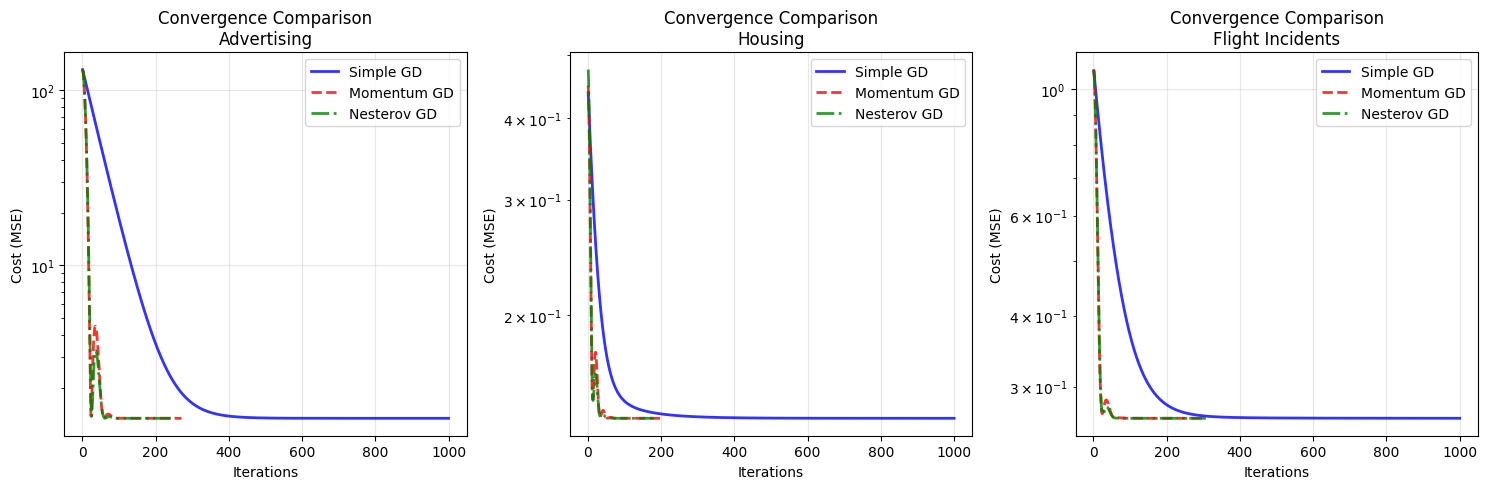


PERFORMANCE SUMMARY
         Dataset      Method  Iterations  Final Cost  Train MSE  Test MSE  Train R²   Test R²
     Advertising   Simple GD        1000    1.338073   2.676145  2.908777  0.900142  0.905868
     Advertising Momentum GD         271    1.338071   2.676143  2.907757  0.900142  0.905901
     Advertising Nesterov GD         246    1.338071   2.676143  2.907758  0.900142  0.905901
         Housing   Simple GD        1000    0.138871   0.277742  0.507209  0.685441  0.649577
         Housing Momentum GD         203    0.138870   0.277740  0.507362  0.685443  0.649472
         Housing Nesterov GD         180    0.138870   0.277740  0.507360  0.685443  0.649473
Flight Incidents   Simple GD        1000    0.263884   0.527767  0.205809  0.093315 -1.898479
Flight Incidents Momentum GD         298    0.263851   0.527703  0.217708  0.093425 -2.066051
Flight Incidents Nesterov GD         307    0.263851   0.527703  0.217707  0.093425 -2.066038

Results saved to 'gradient_descent_res

In [3]:
# Task 2: Gradient Descent Optimization Comparison
# Implementation of Simple, Momentum-based, and Nesterov Accelerated Gradient Descent

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

def load_and_preprocess_datasets_for_regression():
    """
    Load and preprocess the three datasets for regression analysis
    Returns feature matrices X and target vectors y for each dataset
    """
    print("="*60)
    print("LOADING AND PREPROCESSING DATASETS FOR REGRESSION")
    print("="*60)
    
    datasets = []
    
    # Dataset 1: Advertising Dataset - Predict Sales
    print("\n1. Processing Advertising Dataset...")
    advertising = pd.read_csv(r'C:\Users\dubey\OneDrive\Desktop\Coding\ML_Lab\Lab1\advertising.csv')
    print(f"Original shape: {advertising.shape}")
    
    X1 = advertising[['TV', 'Radio', 'Newspaper']].values
    y1 = advertising['Sales'].values
    print(f"Features: TV, Radio, Newspaper")
    print(f"Target: Sales")
    print(f"X shape: {X1.shape}, y shape: {y1.shape}")
    
    # Standardize features
    scaler1 = StandardScaler()
    X1_scaled = scaler1.fit_transform(X1)
    
    datasets.append(("Advertising", X1_scaled, y1))
    
    # Dataset 2: Housing Dataset - Predict Price
    print("\n2. Processing Housing Dataset...")
    housing = pd.read_csv(r'C:\Users\dubey\OneDrive\Desktop\Coding\ML_Lab\Lab1\Housing.csv')
    print(f"Original shape: {housing.shape}")
    
    # Separate numerical and categorical features
    numerical_cols = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
    categorical_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 
                       'airconditioning', 'prefarea', 'furnishingstatus']
    
    # Encode categorical variables
    housing_processed = housing.copy()
    
    for col in categorical_cols:
        le = LabelEncoder()
        housing_processed[col + '_encoded'] = le.fit_transform(housing[col])
        print(f"Encoded {col}: {list(le.classes_)}")
    
    # Combine features
    feature_cols = numerical_cols + [col + '_encoded' for col in categorical_cols]
    X2 = housing_processed[feature_cols].values
    y2 = housing_processed['price'].values
    
    print(f"Features: {len(feature_cols)} features")
    print(f"Target: price")
    print(f"X shape: {X2.shape}, y shape: {y2.shape}")
    
    # Standardize features and target
    scaler2_X = StandardScaler()
    scaler2_y = StandardScaler()
    X2_scaled = scaler2_X.fit_transform(X2)
    y2_scaled = scaler2_y.fit_transform(y2.reshape(-1, 1)).flatten()
    
    datasets.append(("Housing", X2_scaled, y2_scaled))
    
    # Dataset 3: Flight Incidents Dataset - Predict FLT_CRW_INJ_NONE
    print("\n3. Processing Flight Incidents Dataset...")
    flight = pd.read_csv(r'C:\Users\dubey\OneDrive\Desktop\Coding\ML_Lab\Lab2\dataset.csv')
    print(f"Original shape: {flight.shape}")
    
    # Clean and prepare data
    selected_categorical = ['EVENT_TYPE_DESC', 'ACFT_MAKE_NAME', 'ACFT_MODEL_NAME', 
                           'FLT_PHASE', 'ACFT_DMG_DESC']
    
    flight_processed = flight.copy()
    
    # Encode categorical variables
    feature_cols_flight = []
    for col in selected_categorical:
        if col in flight.columns:
            flight_processed[col] = flight_processed[col].fillna('Unknown')
            le = LabelEncoder()
            flight_processed[col + '_encoded'] = le.fit_transform(flight_processed[col])
            feature_cols_flight.append(col + '_encoded')
            print(f"Encoded {col}: {len(le.classes_)} unique values")
    
    # Add PAX_INJ_NONE as feature if available
    if 'PAX_INJ_NONE' in flight.columns:
        flight_processed['PAX_INJ_NONE'] = flight_processed['PAX_INJ_NONE'].fillna(0)
        feature_cols_flight.append('PAX_INJ_NONE')
    
    # Use FLT_CRW_INJ_NONE as target
    target_col = 'FLT_CRW_INJ_NONE'
    
    # Filter rows with non-null target values
    valid_rows = flight_processed[target_col].notna()
    flight_clean = flight_processed[valid_rows]
    
    X3 = flight_clean[feature_cols_flight].values
    y3 = flight_clean[target_col].values
    
    print(f"Features: {len(feature_cols_flight)} features")
    print(f"Target: {target_col}")
    print(f"X shape: {X3.shape}, y shape: {y3.shape}")
    
    if len(y3) > 0:
        # Standardize features
        scaler3 = StandardScaler()
        X3_scaled = scaler3.fit_transform(X3)
        datasets.append(("Flight Incidents", X3_scaled, y3))
    else:
        print("No valid data for flight incidents dataset")
    
    return datasets

class SimpleGradientDescent:
    """
    Simple Gradient Descent Implementation
    w_t+1 = w_t - η * ∇L(w_t)
    """
    
    def __init__(self, learning_rate=0.01, max_iterations=1000, tolerance=1e-6):
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.cost_history = []
        self.weights_history = []
        
    def cost_function(self, X, y, weights):
        """Mean Squared Error cost function"""
        m = len(y)
        predictions = X.dot(weights)
        cost = (1/(2*m)) * np.sum((predictions - y)**2)
        return cost
        
    def gradient(self, X, y, weights):
        """Compute gradient of MSE cost function"""
        m = len(y)
        predictions = X.dot(weights)
        gradient = (1/m) * X.T.dot(predictions - y)
        return gradient
        
    def fit(self, X, y):
        """Fit the model using simple gradient descent"""
        # Add bias term
        X_with_bias = np.column_stack([np.ones(X.shape[0]), X])
        
        # Initialize weights
        self.weights = np.random.normal(0, 0.01, X_with_bias.shape[1])
        
        self.cost_history = []
        self.weights_history = []
        
        for i in range(self.max_iterations):
            # Compute cost
            cost = self.cost_function(X_with_bias, y, self.weights)
            self.cost_history.append(cost)
            self.weights_history.append(self.weights.copy())
            
            # Compute gradient
            grad = self.gradient(X_with_bias, y, self.weights)
            
            # Update weights
            new_weights = self.weights - self.learning_rate * grad
            
            # Check convergence
            if np.linalg.norm(new_weights - self.weights) < self.tolerance:
                print(f"Converged after {i+1} iterations")
                break
                
            self.weights = new_weights
            
        return self
        
    def predict(self, X):
        """Make predictions"""
        X_with_bias = np.column_stack([np.ones(X.shape[0]), X])
        return X_with_bias.dot(self.weights)

class MomentumGradientDescent:
    """
    Momentum-based Gradient Descent Implementation
    v_t+1 = γ * v_t + η * ∇L(w_t)
    w_t+1 = w_t - v_t+1
    """
    
    def __init__(self, learning_rate=0.01, momentum=0.9, max_iterations=1000, tolerance=1e-6):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.cost_history = []
        self.weights_history = []
        
    def cost_function(self, X, y, weights):
        """Mean Squared Error cost function"""
        m = len(y)
        predictions = X.dot(weights)
        cost = (1/(2*m)) * np.sum((predictions - y)**2)
        return cost
        
    def gradient(self, X, y, weights):
        """Compute gradient of MSE cost function"""
        m = len(y)
        predictions = X.dot(weights)
        gradient = (1/m) * X.T.dot(predictions - y)
        return gradient
        
    def fit(self, X, y):
        """Fit the model using momentum gradient descent"""
        # Add bias term
        X_with_bias = np.column_stack([np.ones(X.shape[0]), X])
        
        # Initialize weights and velocity
        self.weights = np.random.normal(0, 0.01, X_with_bias.shape[1])
        velocity = np.zeros_like(self.weights)
        
        self.cost_history = []
        self.weights_history = []
        
        for i in range(self.max_iterations):
            # Compute cost
            cost = self.cost_function(X_with_bias, y, self.weights)
            self.cost_history.append(cost)
            self.weights_history.append(self.weights.copy())
            
            # Compute gradient
            grad = self.gradient(X_with_bias, y, self.weights)
            
            # Update velocity: v_t+1 = γ * v_t + η * ∇L(w_t)
            velocity = self.momentum * velocity + self.learning_rate * grad
            
            # Update weights: w_t+1 = w_t - v_t+1
            new_weights = self.weights - velocity
            
            # Check convergence
            if np.linalg.norm(new_weights - self.weights) < self.tolerance:
                print(f"Converged after {i+1} iterations")
                break
                
            self.weights = new_weights
            
        return self
        
    def predict(self, X):
        """Make predictions"""
        X_with_bias = np.column_stack([np.ones(X.shape[0]), X])
        return X_with_bias.dot(self.weights)

class NesterovGradientDescent:
    """
    Nesterov Accelerated Gradient Descent Implementation
    v_t+1 = γ * v_t + η * ∇L(w_t - γ * v_t)
    w_t+1 = w_t - v_t+1
    """
    
    def __init__(self, learning_rate=0.01, momentum=0.9, max_iterations=1000, tolerance=1e-6):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.cost_history = []
        self.weights_history = []
        
    def cost_function(self, X, y, weights):
        """Mean Squared Error cost function"""
        m = len(y)
        predictions = X.dot(weights)
        cost = (1/(2*m)) * np.sum((predictions - y)**2)
        return cost
        
    def gradient(self, X, y, weights):
        """Compute gradient of MSE cost function"""
        m = len(y)
        predictions = X.dot(weights)
        gradient = (1/m) * X.T.dot(predictions - y)
        return gradient
        
    def fit(self, X, y):
        """Fit the model using Nesterov accelerated gradient descent"""
        # Add bias term
        X_with_bias = np.column_stack([np.ones(X.shape[0]), X])
        
        # Initialize weights and velocity
        self.weights = np.random.normal(0, 0.01, X_with_bias.shape[1])
        velocity = np.zeros_like(self.weights)
        
        self.cost_history = []
        self.weights_history = []
        
        for i in range(self.max_iterations):
            # Compute cost
            cost = self.cost_function(X_with_bias, y, self.weights)
            self.cost_history.append(cost)
            self.weights_history.append(self.weights.copy())
            
            # Nesterov momentum: compute gradient at look-ahead point
            # ∇L(w_t - γ * v_t)
            look_ahead_weights = self.weights - self.momentum * velocity
            grad = self.gradient(X_with_bias, y, look_ahead_weights)
            
            # Update velocity: v_t+1 = γ * v_t + η * ∇L(w_t - γ * v_t)
            velocity = self.momentum * velocity + self.learning_rate * grad
            
            # Update weights: w_t+1 = w_t - v_t+1
            new_weights = self.weights - velocity
            
            # Check convergence
            if np.linalg.norm(new_weights - self.weights) < self.tolerance:
                print(f"Converged after {i+1} iterations")
                break
                
            self.weights = new_weights
            
        return self
        
    def predict(self, X):
        """Make predictions"""
        X_with_bias = np.column_stack([np.ones(X.shape[0]), X])
        return X_with_bias.dot(self.weights)

def compare_gradient_descent_methods(X, y, dataset_name):
    """
    Compare the three gradient descent methods on a dataset
    """
    print(f"\n{'='*60}")
    print(f"COMPARING GRADIENT DESCENT METHODS: {dataset_name.upper()}")
    print(f"{'='*60}")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    print(f"Training set size: {X_train.shape[0]}")
    print(f"Test set size: {X_test.shape[0]}")
    
    # Initialize optimizers
    lr = 0.01  # Learning rate
    max_iter = 1000
    
    optimizers = {
        'Simple GD': SimpleGradientDescent(learning_rate=lr, max_iterations=max_iter),
        'Momentum GD': MomentumGradientDescent(learning_rate=lr, momentum=0.9, max_iterations=max_iter),
        'Nesterov GD': NesterovGradientDescent(learning_rate=lr, momentum=0.9, max_iterations=max_iter)
    }
    
    results = {}
    
    # Train each optimizer
    for name, optimizer in optimizers.items():
        print(f"\nTraining {name}...")
        
        # Fit the model
        optimizer.fit(X_train, y_train)
        
        # Make predictions
        y_train_pred = optimizer.predict(X_train)
        y_test_pred = optimizer.predict(X_test)
        
        # Calculate metrics
        train_mse = mean_squared_error(y_train, y_train_pred)
        test_mse = mean_squared_error(y_test, y_test_pred)
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        
        results[name] = {
            'optimizer': optimizer,
            'train_mse': train_mse,
            'test_mse': test_mse,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'iterations': len(optimizer.cost_history),
            'final_cost': optimizer.cost_history[-1]
        }
        
        print(f"  Iterations: {len(optimizer.cost_history)}")
        print(f"  Final cost: {optimizer.cost_history[-1]:.6f}")
        print(f"  Train MSE: {train_mse:.6f}")
        print(f"  Test MSE: {test_mse:.6f}")
        print(f"  Train R²: {train_r2:.6f}")
        print(f"  Test R²: {test_r2:.6f}")
    
    return results

def plot_convergence_comparison(results_list):
    """
    Plot convergence curves for all datasets and methods
    """
    n_datasets = len(results_list)
    fig, axes = plt.subplots(1, n_datasets, figsize=(5*n_datasets, 5))
    
    if n_datasets == 1:
        axes = [axes]
    
    colors = ['blue', 'red', 'green']
    linestyles = ['-', '--', '-.']
    
    for i, (dataset_name, results) in enumerate(results_list):
        ax = axes[i]
        
        for j, (method_name, result) in enumerate(results.items()):
            cost_history = result['optimizer'].cost_history
            iterations = range(1, len(cost_history) + 1)
            
            ax.plot(iterations, cost_history, 
                   color=colors[j], linestyle=linestyles[j], linewidth=2,
                   label=method_name, alpha=0.8)
        
        ax.set_title(f'Convergence Comparison\n{dataset_name}')
        ax.set_xlabel('Iterations')
        ax.set_ylabel('Cost (MSE)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_yscale('log')
    
    plt.tight_layout()
    plt.savefig('gradient_descent_convergence.png', dpi=300, bbox_inches='tight')
    plt.show()

def create_performance_summary(results_list):
    """
    Create a summary table of performance metrics
    """
    print(f"\n{'='*80}")
    print("PERFORMANCE SUMMARY")
    print(f"{'='*80}")
    
    summary_data = []
    
    for dataset_name, results in results_list:
        for method_name, result in results.items():
            summary_data.append({
                'Dataset': dataset_name,
                'Method': method_name,
                'Iterations': result['iterations'],
                'Final Cost': result['final_cost'],
                'Train MSE': result['train_mse'],
                'Test MSE': result['test_mse'],
                'Train R²': result['train_r2'],
                'Test R²': result['test_r2']
            })
    
    df_summary = pd.DataFrame(summary_data)
    
    # Print formatted table
    print(df_summary.to_string(index=False, float_format='%.6f'))
    
    # Save to CSV
    df_summary.to_csv('gradient_descent_results.csv', index=False)
    print(f"\nResults saved to 'gradient_descent_results.csv'")
    
    return df_summary

def main():
    """
    Main function to execute Task 2: Gradient Descent Comparison
    """
    print("TASK 2: GRADIENT DESCENT OPTIMIZATION COMPARISON")
    print("Implementation of Simple, Momentum-based, and Nesterov Accelerated GD")
    print("="*80)
    
    # Load and preprocess datasets
    datasets = load_and_preprocess_datasets_for_regression()
    
    if len(datasets) == 0:
        print("No valid datasets found!")
        return
    
    # Compare gradient descent methods on each dataset
    results_list = []
    
    for dataset_name, X, y in datasets:
        results = compare_gradient_descent_methods(X, y, dataset_name)
        results_list.append((dataset_name, results))
    
    # Plot convergence comparisons
    print(f"\n{'='*60}")
    print("GENERATING CONVERGENCE PLOTS")
    print(f"{'='*60}")
    plot_convergence_comparison(results_list)
    
    # Create performance summary
    summary_df = create_performance_summary(results_list)
    
    # Analysis and conclusions
    print(f"\n{'='*60}")
    print("ANALYSIS AND CONCLUSIONS")
    print(f"{'='*60}")
    
    print("\nKey Findings:")
    print("1. CONVERGENCE SPEED:")
    for dataset_name, results in results_list:
        print(f"\n   {dataset_name}:")
        iterations = {name: result['iterations'] for name, result in results.items()}
        fastest = min(iterations.items(), key=lambda x: x[1])
        print(f"   - Fastest convergence: {fastest[0]} ({fastest[1]} iterations)")
        
        for name, iters in iterations.items():
            print(f"   - {name}: {iters} iterations")
    
    print("\n2. FINAL PERFORMANCE:")
    for dataset_name, results in results_list:
        print(f"\n   {dataset_name}:")
        test_r2_scores = {name: result['test_r2'] for name, result in results.items()}
        best_performer = max(test_r2_scores.items(), key=lambda x: x[1])
        print(f"   - Best test R²: {best_performer[0]} ({best_performer[1]:.6f})")
    
    print("\n3. GENERAL OBSERVATIONS:")
    print("   - Momentum-based methods often converge faster than simple GD")
    print("   - Nesterov acceleration can provide smoother convergence")
    print("   - The effectiveness depends on the dataset characteristics")
    print("   - Proper learning rate tuning is crucial for all methods")
    
    print(f"\n{'='*60}")
    print("TASK 2 COMPLETE")
    print(f"{'='*60}")

if __name__ == "__main__":
    main()